In [8]:
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
import math
rcParams['figure.figsize'] = 10, 10
from scipy.signal import gaussian, convolve2d
from numpy.fft import fft2, ifft2

import warnings
warnings.filterwarnings('ignore')

In [2]:
def fix_image(image):
    #hist_equalization

    # clip all negative values to 0
    image = image.clip(min=0)

    # scale within the interval [0,255]
    image *= 255 / np.max(image)

    # calculate image histogram, with 256 bins returning probability density of each bin
    image_histogram, bins = np.histogram(image.flatten(), 256, normed=True)
    
    # compute the image's cumulative distribution function (CDF)
    cdf = image_histogram.cumsum()
    cdf = 255 * cdf / cdf[-1]

    # use linear interpolation of the CDF to adjust the image
    return np.interp(image.flatten(), bins[:-1], cdf).reshape(image.shape)

In [3]:
def distance(x, y, i, j):
    return np.sqrt((x-i)**2 + (y-j)**2)


def gaussian_bi(x, sigma):
    return (1.0 / (2 * math.pi * (sigma ** 2))) * math.exp(- (x ** 2) / (2 * sigma ** 2))


def apply_bilateral_filter(source, filtered_image, x, y, diameter, sigma_i, sigma_s):
    hl = diameter/2
    i_filtered = 0
    Wp = 0
    i = 0
    while i < diameter:
        j = 0
        while j < diameter:
            neighbour_x = x - (hl - i)
            neighbour_y = y - (hl - j)
            if neighbour_x >= len(source):
                neighbour_x -= len(source)
            if neighbour_y >= len(source[0]):
                neighbour_y -= len(source[0])
            gi = gaussian_bi(source[neighbour_x][neighbour_y] - source[x][y], sigma_i)
            gs = gaussian_bi(distance(neighbour_x, neighbour_y, x, y), sigma_s)
            w = gi * gs
            i_filtered += source[neighbour_x][neighbour_y] * w
            Wp += w
            j += 1
        i += 1
    i_filtered = i_filtered / Wp
    filtered_image[x][y] = int(round(i_filtered))

def apply_bilateral_filter(source, filtered_image, x, y, diameter, sigma_i, sigma_s):
    hl = diameter/2
    i_filtered = 0
    Wp = 0
    i = 0
    while i < diameter:
        j = 0
        while j < diameter:
            neighbour_x = x - (hl - i)
            neighbour_y = y - (hl - j)
            if neighbour_x >= len(source):
                neighbour_x -= len(source)
            if neighbour_y >= len(source[0]):
                neighbour_y -= len(source[0])
            gi = gaussian_bi(source[neighbour_x][neighbour_y] - source[x][y], sigma_i)
            gs = gaussian_bi(distance(neighbour_x, neighbour_y, x, y), sigma_s)
            w = gi * gs
            i_filtered += source[neighbour_x][neighbour_y] * w
            Wp += w
            j += 1
        i += 1
    i_filtered = i_filtered / Wp
    filtered_image[x][y] = int(round(i_filtered))
    
    

def bilateral_filter_own(source, filter_diameter, sigma_i, sigma_s):
    filtered_image = np.zeros(source.shape)

    i = 0
    while i < len(source):
        if(i%100 == 0):
            print(i)
        j = 0
        while j < len(source[0]):
            apply_bilateral_filter(source, filtered_image, i, j, filter_diameter, sigma_i, sigma_s)
            j += 1
        i += 1
    return filtered_image

In [4]:
def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def wiener_filter(img, size, K):
    kernel = gaussian_kernel(size)
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [6]:
# def wiener_filter(img, K):
#     dummy = np.copy(img)
#     G = fft2(dummy)
#     H = np.conj(G) / (np.abs(G) ** 2 + K)
#     go = np.abs(ifft2(G*H))
#     return go

In [5]:
def noisy(image,noise_typ,control):
    if noise_typ == "gaussian":
        row,col = image.shape
        mean = 127
        var = control
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "sp":
        row,col = image.shape
        s_vs_p = 0.5
        amount = control
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[coords] = 255
        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "uniform":
        frac = control
        row,col = image.shape
        uniform_matrix = np.zeros((image.shape[0], image.shape[1]))
        rand_prop = np.random.binomial(1, frac, size=row*col).reshape(image.shape)
        rand_uniform = rand_prop * cv2.randu(uniform_matrix,90,200)
        noisy = image + rand_uniform
        return noisy
        

In [6]:
img = cv2.imread('lamp.jpeg',0)
blur = cv2.GaussianBlur(img,(5,5),0)

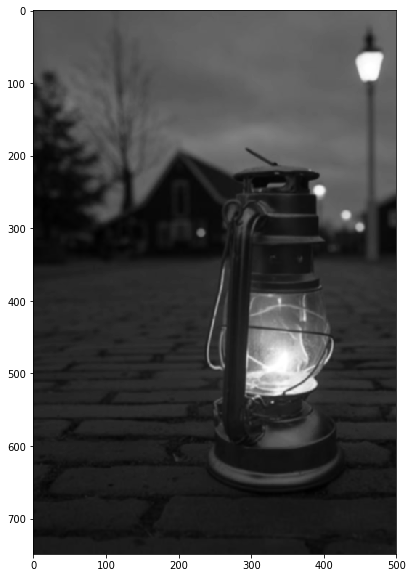

In [9]:
plt.imshow(blur,cmap='gray')

In [18]:
sp = noisy(blur,'uniform',0.01).astype(np.float32)

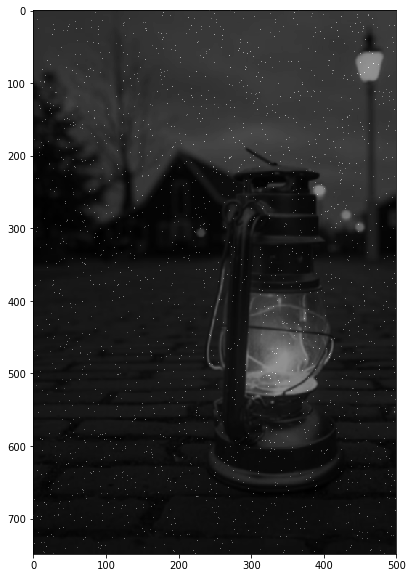

In [19]:
plt.imshow(sp,cmap='gray')

In [129]:
# bi = bilateral_filter_own(sp, 3, 208.0, 208.0)
# plt.imshow(bi,cmap='gray')

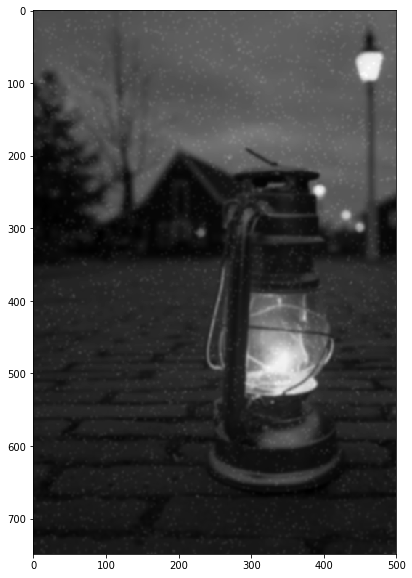

In [24]:
low = cv2.GaussianBlur(sp,(7,7),0)
plt.imshow(low,cmap='gray')

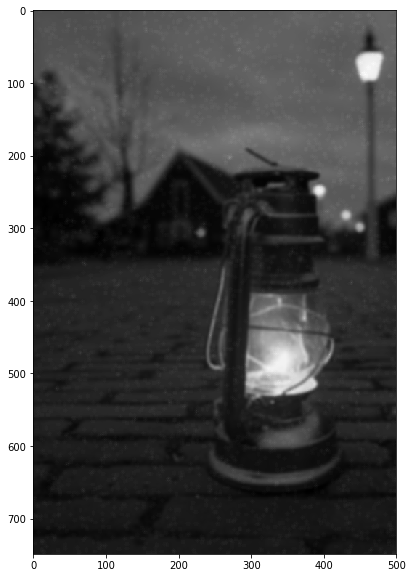

In [25]:
bi = cv2.bilateralFilter(sp, 7, 198.0, 198.0)
plt.imshow(bi,cmap='gray')

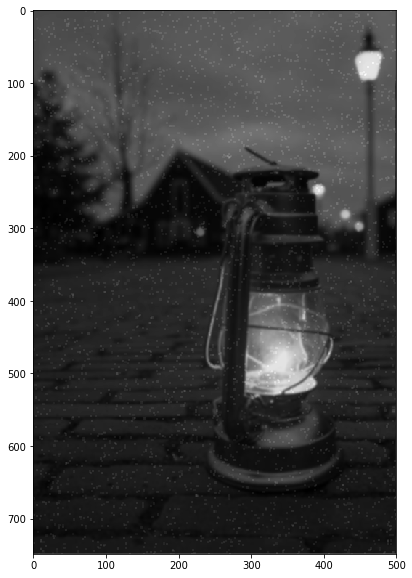

In [26]:
bi = wiener_filter(sp, size=3, K=1000)
plt.imshow(bi,cmap='gray')